**rajvi using steph's code**

In [240]:
from rajvi_mapbox_api import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
import folium


In [241]:
branches = pd.read_csv('../data/clean/branches.csv')
populationDemographics = pd.read_csv('../data/clean/population_demographics.csv')

In [242]:
api = MapboxAPI()

In [243]:
response = api.get_data((41.97557881655979, -87.71361314512697), 15)
#response

In [244]:
branchRadii = gpd.read_file('../data/clean/branches.csv')

branchRadii[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchRadii['LOCATION']]
branchRadii.loc[:, 'LATITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LATITUDE'])
branchRadii.loc[:, 'LONGITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LONGITUDE'])
branchRadii.head()

#for i in range(branchRadii.shape[0]):
#    api_response =  api.get_data((branchRadii.loc[i,'LATITUDE'],branchRadii.loc[i,'LONGITUDE']), 5)
#    branchRadii.loc[i,'geometry'] = shape(api_response)

api_response = api.get_data((branchRadii.loc[0,'LATITUDE'],branchRadii.loc[0,'LONGITUDE']), 5)
branchRadii.loc[0,'geometry'] = shape(api_response)

/tmp/ipykernel_1431650/3565714116.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
/tmp/ipykernel_1431650/3565714116.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]


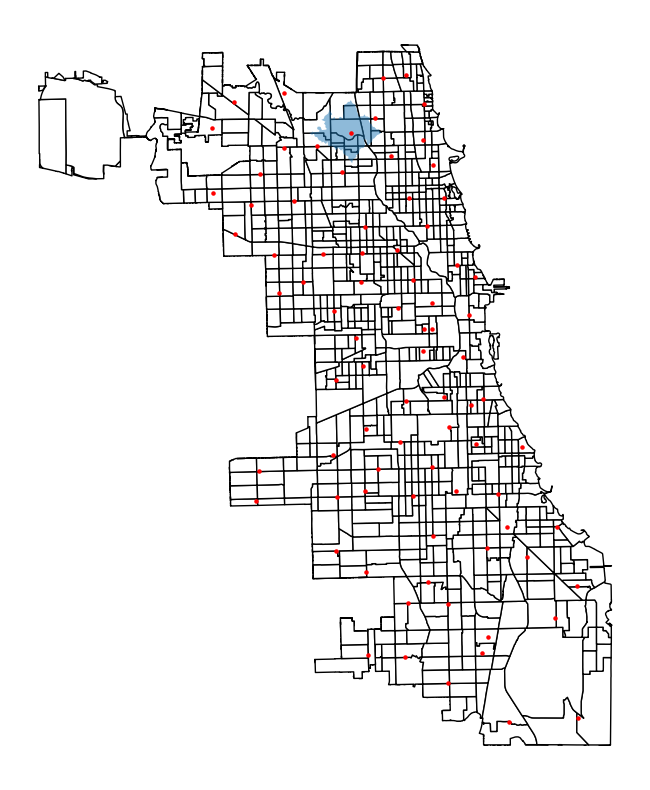

In [245]:
# this line makes a copy of the ageOnly data frame so we can manipulate without affecting our primary dataset
censusTracts = populationDemographics[['geoid','geometry','qualifying name', 'current land area (sq. m)']]
branchLocsOnly=branches[['BRANCH','LOCATION']]

# the following converts the data frame to a geo data frame and plots estimated percent of retired members of each community
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

branchLocsOnly.crs = 'EPSG:4326'
branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
branchLocsOnly = branchLocsOnly.drop(columns='LOCATION')
#branchLocsOnly.head()

branchLocsOnly = gpd.GeoDataFrame(
    branchLocsOnly, geometry=gpd.points_from_xy(branchLocsOnly.Longitude, branchLocsOnly.Latitude), crs="EPSG:4326")


fig, ax = plt.subplots(1, figsize=(10, 10))
base = censusTracts.plot(ax=ax, color='white', edgecolor='black')
ax.axis('off')

branchRadii.plot(ax=base, alpha = .5)
branchLocsOnly.plot(ax=base, marker='o', color='red', markersize=5);

In [201]:
branchRadii = branchRadii.set_crs('epsg:4326')
print(branchRadii.crs)

epsg:4326


In [161]:
#print(censusTracts.shape[0])
#censusTracts0to81 = censusTracts.loc[0:82]
#censusTracts82to193 = censusTracts.loc[82:194]
#censusTracts194to275 = censusTracts.loc[194:276]
#censusTracts276to357 = censusTracts.loc[276:358]
#censusTracts358to439 = censusTracts.loc[358:440]
#censusTracts440to521 = censusTracts.loc[440:522]
#censusTracts522to603 = censusTracts.loc[522:604]
#censusTracts643to685 = censusTracts.loc[604:686]
#censusTracts686to767 = censusTracts.loc[686:768]
#censusTracts768to849 = censusTracts.loc[768:850]
#censusTracts787to869 = censusTracts.loc[788:870]
#censusTracts.head(5)

In [248]:
#branchRadii.intersection(censusTracts787to869, align=True)

albanyPark=pd.DataFrame
albanyPark = pd.DataFrame(columns=['Census Tract','geometry'])
albanyPark.reset_index(inplace = True)

for index, row in censusTracts.iterrows():
    if ((branchRadii.intersection(row['geometry']))[0]).is_empty:
        empty.append("none")
        empty=[]
    else:
        temp = pd.DataFrame({"Census Tract": row['geoid'],"geometry": [(branchRadii.intersection(row['geometry'])[0])]}, index=[0])
        albanyPark=pd.concat([albanyPark,temp])

albanyPark = gpd.GeoDataFrame(albanyPark, crs="EPSG:4326")
albanyPark.reset_index(inplace = True)
albanyPark=albanyPark.drop(['level_0', 'index'], axis=1)

albanyPark= albanyPark.to_crs({'init': 'epsg:32633'})
albanyPark["Area Within Radius"] = albanyPark['geometry'].area/ 10**6


censusTracts= censusTracts.to_crs({'init': 'epsg:32633'})
def tractArea(row):
    for index, tracts in censusTracts.iterrows():
        if row['Census Tract'] == tracts['geoid']:
            return tracts['current land area (sq. m)'] / 10**6

albanyPark['Tract Area']= albanyPark.apply(tractArea, axis=1)

#def percentInTract(row):
#    for index, tracts in censusTracts.iterrows():
#        if row['Census Tract'] == tracts['geoid']:
#            return row['Area Within Radius']/tracts['current land area (sq. m)']      
#albanyPark['Percent Overlap']= albanyPark.apply(percentInTract, axis=1)

albanyPark['Percent Overlap'] = albanyPark['Area Within Radius']/albanyPark['Tract Area']*100
albanyPark

/opt/tljh/user/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/tljh/user/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/tljh/user/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Census Tract                                           geometry  \
0   17031140800  POLYGON ((-5362723.304 11526358.296, -5362651....   
1   17031160501  POLYGON ((-5363389.242 11527528.859, -5363674....   
2   17031140702  POLYGON ((-5363271.129 11527810.079, -5363172....   
3   17031140601  POLYGON ((-5362128.569 11528693.797, -5361962....   
4   17031140602  POLYGON ((-5362722.651 11528099.532, -5362579....   
5   17031140701  POLYGON ((-5362074.226 11527745.426, -5362082....   
6   17031140301  POLYGON ((-5361673.022 11528973.648, -5361661....   
7   17031140200  POLYGON ((-5361427.898 11527542.908, -5361457....   
8   17031140100  POLYGON ((-5362035.221 11526047.304, -5362579....   
9   17031140302  POLYGON ((-5360585.206 11528547.010, -5360591....   
10  17031040300  POLYGON ((-5362512.491 11525687.986, -5362626....   
11  17031831800  POLYGON ((-5359461.427 11528209.238, -5359481....   
12  17031130300  POLYGON ((-5358684.044 11526763.389, -5358706....   
13  17031020701  POLYGON ((-5360091.343 11525469.545, -5359976....   
14  17031130100  MULTIPOLYGON (((-5358637.830 11526742.960, -53...   
15  17031140400  POLYGON ((-5361593.488 11529175.556, -5361177....   
16  17031130200  POLYGON ((-5359949.204 11530417.059, -5360015....   
17  17031040201  POLYGON ((-5361950.989 11524460.540, -5362022....   
18  17031040202  MULTIPOLYGON (((-5361896.140 11524477.033, -53...   

    Area Within Radius  Tract Area  Percent Overlap  
0             0.166430    0.714365        23.297662  
1             0.050482    0.345248        14.622085  
2             0.688494    0.427095       161.203884  
3             0.057090    0.272123        20.979621  
4             0.234324    0.384380        60.961452  
5             0.479810    0.228328       210.140647  
6             0.344354    0.164129       209.806895  
7             0.828801    0.394455       210.112883  
8             0.533322    0.282494       188.790390  
9             0.871246    0.414720       210.080638  
10            1.466321    0.752564       194.843376  
11            4.013554    1.910736       210.052789  
12            1.408238    0.721103       195.289411  
13            0.198731    0.591396        33.603673  
14            0.410179    1.839635        22.296744  
15            0.790081    1.181559        66.867684  
16            1.446957    2.075998        69.699351  
17            0.447078    0.721413        61.972506  
18            0.188756    0.588657        32.065560